In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../..'))

from PySDM.physics import si
from PySDM.initialisation.spectral_sampling import constant_multiplicity
from PySDM.initialisation.spectra import Exponential, Lognormal
from PySDM.physics.formulae import volume

n_sd = 2**13
initial_spectrum = Exponential(norm_factor=8.39e12, scale=1.19e5 * si.um**3)
init_x_min = volume(radius=10 * si.um)
init_x_max = volume(radius=100 * si.um)
sampling_range = (init_x_min, init_x_max)
attributes = {}
attributes['volume'], attributes['n'] =\
    constant_multiplicity(n_sd=n_sd, spectrum=initial_spectrum, range=sampling_range)

/home/csinger/anaconda3/envs/pysdm/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
from PySDM.builder import Builder
from PySDM.attributes.attribute import Attribute
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import ConstKern, Golovin
from PySDM.backends import Numba
from PySDM.state.products.particles_volume_spectrum import ParticlesVolumeSpectrum
import numpy as np

particles_builder = Builder(n_sd=n_sd, backend=Numba)
env = Box(dt = 1*si.s, dv=1e6*si.m**3)
particles_builder.set_environment(env)
coal = Coalescence(kernel=ConstKern(kernel_const = 1e-6 / si.s))
#coal = Coalescence(kernel=Golovin(b = 0 / si.s))
#coal = Coalescence(kernel=Golovin(b = 1e3 / si.s))
attributes = {}
attributes['volume'], attributes['n'] = constant_multiplicity(n_sd, initial_spectrum, (init_x_min, init_x_max))
particles_builder.add_dynamic(coal)
products = [ParticlesVolumeSpectrum()]
particles = particles_builder.build(attributes, products)

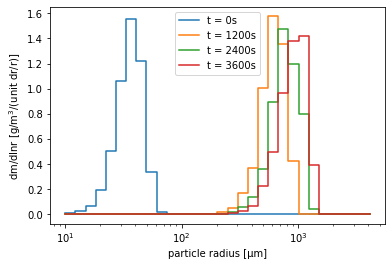

In [4]:
from PySDM.physics.constants import rho_w
from matplotlib import pyplot
import numpy as np

radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(5e3 * si.um), num=32)

for step in [0, 1200, 2400, 3600]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=radius_bins_edges[:-1] / si.um,
                y=particles.products['dv/dlnr'].get(radius_bins_edges) * rho_w / si.g,
                where='post', label=f"t = {step}s")

pyplot.xscale('log')
pyplot.xlabel('particle radius [µm]')
pyplot.ylabel("dm/dlnr [g/m$^3$/(unit dr/r)]")
pyplot.legend()
pyplot.show()